# **Adot URLs Topic Classification Challenge**

In this notebook, I try to select models appropriated to deal with the topic classification challenge proposed by Adot. I start with a simple analysis of the data before tackling the model selection problem. Limited by the resources allowed in my humble computer, I work with Keras built-in models and a simple architecture of a neural network model using Tensorflow.

Remark: In order to use pretrained word vectors, it is important to download the word embeddings file through the link below:

https://nlp.stanford.edu/data/glove.6B.zip

The file called 'glove.6B.300d.txt' is to be put in the data/glove_word_embeddings directory.

### Modules and functions imports

In [ ]:
pip install --user -r requirements.txt

In [ ]:
pip install --user --upgrade numpy

In [1]:
from utils import plot_history, create_embedding_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fastparquet

from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

### Data Analysis and Preprocessing

In this section, I tried to explore the data especially the targeted label to understand how to effectively transform and preprocess the data to ensure compatibility as inputs for the models proposed

In [2]:
# Read data into pandas DataFrame
data_dir = Path('./data/')
full_df = pd.concat(
    pd.read_parquet(parquet_file, )
    for parquet_file in data_dir.glob('*.parquet')
)
full_df.reset_index(drop=True, inplace=True)

In [3]:
full_df.head()

,url,target,day
0,https://www.cdiscount.com/bricolage/electricit...,"[1831, 1751, 1192, 745, 1703]",4
1,https://www.mystalk.net/profile/vitoriafcorrea,"[847, 978, 582, 1381, 529]",4
2,https://www.lequipe.fr/Tennis/TennisFicheJoueu...,"[20, 1077, 294]",4
3,http://m.jeuxvideo.com/forums/42-32625-6018005...,"[381, 935, 1343, 622, 933]",4
4,https://context.reverso.net/traduction/espagno...,"[692, 1265, 725, 1264, 1266]",4


In [4]:
#Transform target into a binary matrix of the possible labels using MultilabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(full_df['target'])
categories = mlb.classes_
y = pd.DataFrame(y, columns=categories)

In [5]:
print(categories)
print(len(categories))
occ = []
for category in categories:
    occ.append(np.bincount(y[category]))
    
print('Label:',categories[25], 'has' ,occ[25][1], 'occurences')

['100' '1000' '1001' ... '997' '998' '999']
1903
Label: 1023 has 54 occurences


In [6]:
#Preprocess urls by removing punctuation for vectorization purposes
full_df['url'].replace(to_replace='[^\w\s]', value=' ', inplace=True, regex=True)
print(full_df['url'][0])

https   www cdiscount com bricolage electricite batterie plomb 6v 4ah ova51023e pour toplux f 16614 ova2009927775303 html


In [7]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(full_df, y, test_size=0.33, random_state=42)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [8]:
#urls data vectorization
embedding = False
if embedding:
    tokenizer = Tokenizer(num_words=90000)
    tokenizer.fit_on_texts(X_train['url'])

    url_train = tokenizer.texts_to_sequences(X_train['url'])
    url_test = tokenizer.texts_to_sequences(X_test['url'])

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = 50

    url_train = pad_sequences(url_train, padding='post', maxlen=maxlen)
    url_test = pad_sequences(url_test, padding='post', maxlen=maxlen)
else:
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train['url'])
    url_train = vectorizer.fit_transform(X_train['url'])
    url_test = vectorizer.transform(X_test['url'])
    url_train.sort_indices()
    url_test.sort_indices()

### Model Selection

In [9]:
neural=True
onevrest=True

#### Neural Network

In this section, I tried to use neural networks but due to limited resources in time and memory processing, I have built a simple model with a single Dense layer and an output dense layer. There is always room for improvement in this architecture by increasing the model's complexity hence improving the performance of the model for this problem.

We have two possible builds of the neural network, if the embedding parameter is set to True, we use pretrained word2vec embeddings as initial weights in the embedding layer, else we use an Input layer with vectorized text using CountVectorizer

In [10]:
embedding = False


if neural:
    input_dim = url_train.shape[1]
    loss='binary_crossentropy'
    optimizer='adam'
    metric=['accuracy']

    model = Sequential()
    if embedding:
        embedding_dim = 300
        embedding_matrix = create_embedding_matrix('data/glove_word_embeddings/glove.6B.300d.txt',
                                                   tokenizer.word_index, embedding_dim)
        model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
        model.add(layers.Flatten())
    else:
        model.add(layers.InputLayer(input_shape=(input_dim,), sparse=True))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(1903, activation='sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

#### OnevsRest Classifier

Here, I build a pipeline using Keras module composed of a Tfidf vectorizer for text vectorization and for classification, I used OnevsRest Classifier in which a binary classifier is fitted on each label against the rest of the labels, this method of course cannot process the correlation between categories and may oversee useful information for performance improvement.

In [16]:
if onevrest:

    classif = 'sgd' #possible classifiers: 'sgd' 'xgboost', 'logistic', 'logisticCV'

    if classif=='xgboost':
        clf = OneVsRestClassifier(XGBClassifier())
    elif classif=='sgd':
        clf = OneVsRestClassifier(SGDClassifier(loss='log', class_weight='balanced', max_iter=1000))
    elif classif=='logistic':
        clf = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced', solver='liblinear', max_iter=10000))
    elif classif=='logisticCV':
        clf = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced', solver='liblinear', max_iter=10000))
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf', clf)])


### Model Training and evaluation

#### Neural network

##### Training

In [12]:
if neural:
    history = model.fit(url_train, y_train, epochs=25, verbose=False, validation_data=(url_test, y_test), batch_size=500)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 200), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


##### Evaluation

In [13]:
if neural:
    loss, accuracy = model.evaluate(url_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(url_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.1832
Testing Accuracy:  0.1551


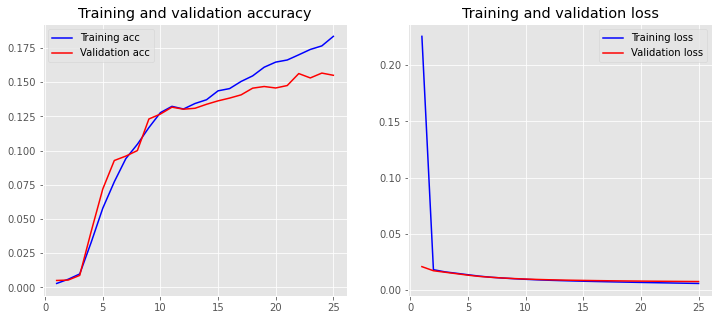

In [14]:
plot_history(history)

#### OnevsRest Classifier

##### Training

In [17]:
if onevrest:
    text_clf.fit(X_train['url'], y_train)

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 385 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 445 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 464 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
 

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 1356 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 1385 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 1396 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\multiclass.py:81: UserWarning: Label not 1397 is present in all training examples.
  str(classes[c]))
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\skl

##### Evaluation

In [18]:
if onevrest:
    prediction = text_clf.predict(X_test['url'])

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test recall is 0.7730938243956602
F1 score 0.37639035616573174


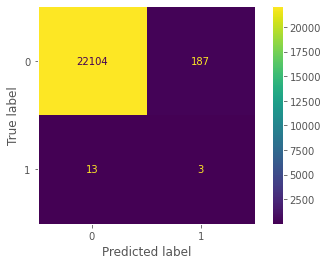

In [19]:
if onevrest:
    print('Test recall is {}'.format(recall_score(y_test, prediction, average='weighted')))
    print('F1 score {}'.format(f1_score(y_test, prediction, average='weighted')))
    c = multilabel_confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(c[25])
    disp.plot()
    plt.grid(False)
    plt.show()

### Conclusion

I have limited this study to the text features contained in the URLs with potentially adding the 'day' feature, performances may improve.

Based on this work, using a simple architecture in neural network is limited to 16% accuracy on test data, with future studies and development on the model, there is much room for improvement in terms of performance and time management for the training.

For the OneVsRest Classifier, this was a viable option given the memory allocation of the data to fit this problem in a built-in classifier compared to other possible solutions with potentially better performances e.g Classifier Chains or Label Powersets. Although, the accuracy for each label is satisfying especially for SGDClassifier and LogisticRegressionCV whilst XGBClassifier and LogisticRegression take too much time to compute, it is due to the successfully predicted negatives which is why I tried to study Recall and F1 Score rather than accuracy, having a limited number of occurences for the labels, limits the training and directs the model for having many false negatives which is a problem mainly caused by the imbalance in the data. This problem is even noticed in the absence of positive values for some labels in the training data.
This work may be considered as a mere introduction to develop a model with solid performances for this multi-label problem.